In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import json
import pandas as pd
import numpy as np
import pyvista as pv
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from lsh import LSH, L1_LSH

import time
import math
from scipy.spatial import KDTree

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
vec_size = 

table = LSH(error_rate=0.10, max_k=15)
dataset = 2 * np.random.rand( 1000, vec_size ) + 100

table.build(dataset, early_stop_k=10)

Starting to search for optimal k


  0%|          | 0/14 [00:00<?, ?it/s]


            Built LSH
                class:             L1_LSH
                N objects:         1000
                N dims:            256
                k:                 6
                L:                 18
                R (after norm):    75.90
                Error rate:        0.1

                Avg collisions:    141.43
                Avg query time:    9.438037872314453e-05 s.
            


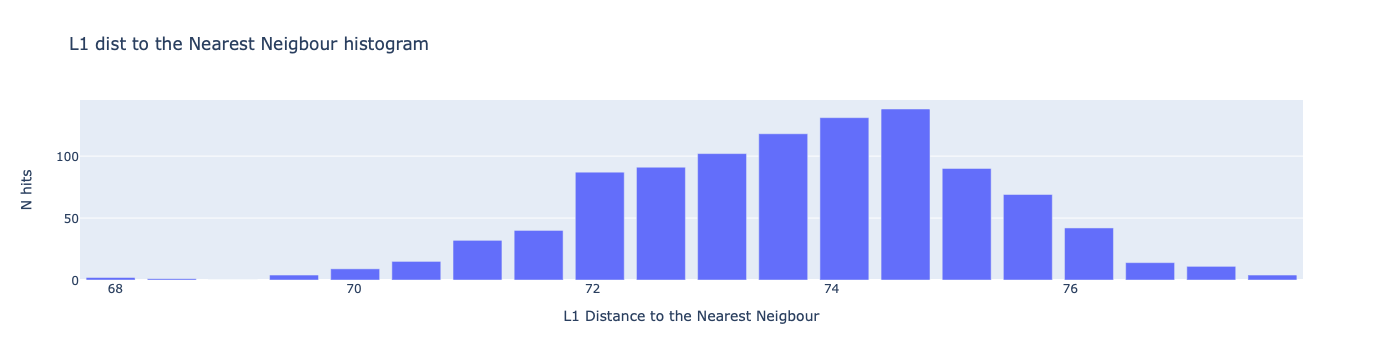

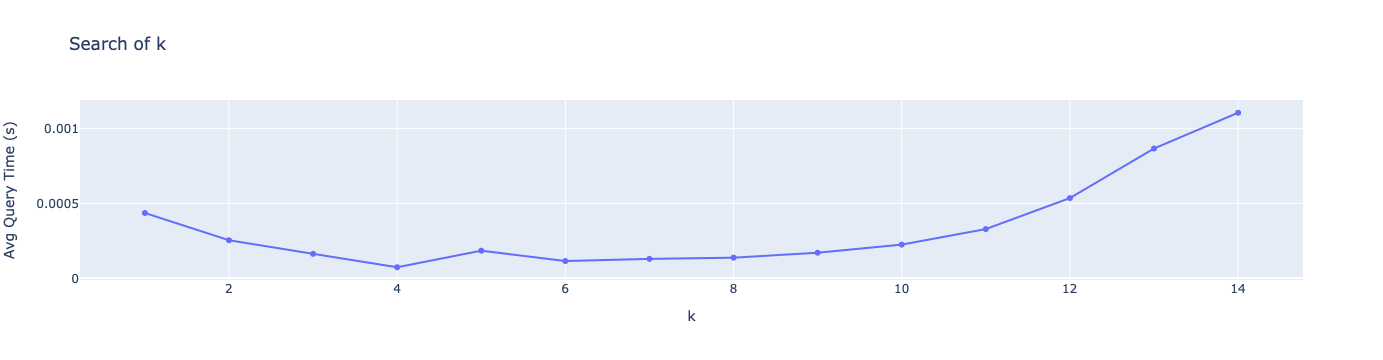

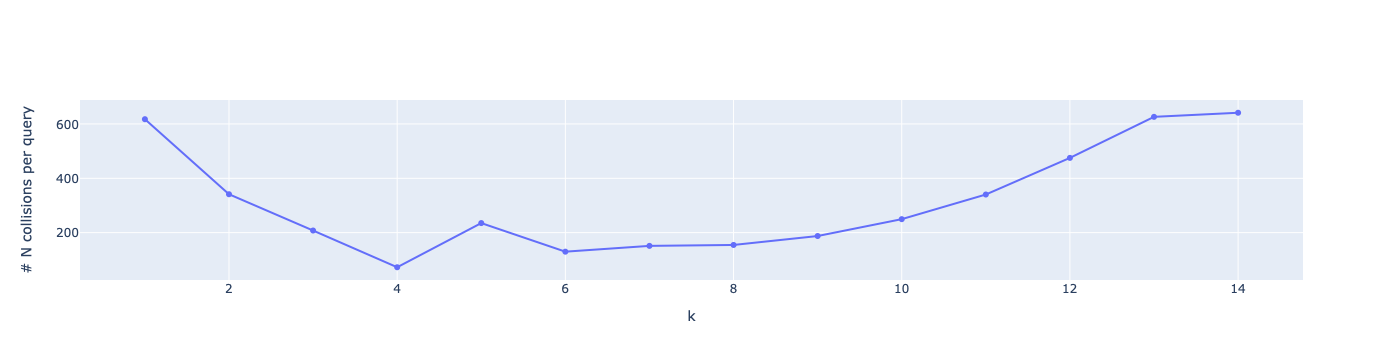


            Built LSH
                class:             L1_LSH
                N objects:         1000
                N dims:            256
                k:                 4
                L:                 9
                R (after norm):    75.89
                Error rate:        0.1

                Avg collisions:    235.16
                Avg query time:    7.137537002563477e-05 s.
            


In [6]:
table.plot_info(save_name="test_data")

# Check Error Rate

In [8]:
n_avg = 10000
vec_size = 256
dataset = np.random.rand( 1000, vec_size )

query_vectors = np.random.rand(n_avg, vec_size)

In [9]:
table = LSH(error_rate=0.01, max_k=10)
table.build(dataset, objects=range(dataset.shape[0]), verbose=False)

In [11]:
exact_count = 0
error_count = [0, 0, 0, 0]
naive_perf = np.array([])
hash_perf = np.array([])

for vec in query_vectors:
    hash_vec, hash_idx, hash_dist = table.get_nearest_neigbour(vec)
    if hash_dist is None:
        hash_dist = 1e10  # Assign infiny so that we dont count it later
    else:
        hash_dist = np.sum(np.abs(vec - hash_vec))

    distances = np.sum(np.abs(vec[None, :] - dataset), axis=1)
    naive_dist = np.min(distances)
    naive_idx = np.argmin(distances)
    
    if naive_idx == hash_idx:
        exact_count += 1
    if naive_dist <= table._R:
        error_count[-1] += 1
    if hash_dist is None:
        error_count[1] += 1
        error_count[0] += 1
        error_count[2] += 1
    elif hash_dist > 1.05 * table._R:
        error_count[0] += 1
        error_count[2] += 1
    elif hash_dist > table._R:
        error_count[0] += 1
    hash_perf = np.append(hash_perf, hash_dist)
    naive_perf = np.append(naive_perf, naive_dist)

print(f"Exact rate: {exact_count / n_avg * 100:.2f}%")
print(\
    f"""
    When there is point closer then R
        returned nothing:                 {error_count[1] / error_count[-1] * 100:.2f}%
        returned outside of R:            {error_count[0] / error_count[-1] * 100:.2f}%
        returned outside of 1.05 * R:     {error_count[2] / error_count[-1] * 100:.2f}%
    """
)

Exact rate: 22.17%

    When there is point closer then R
        returned nothing:                 0.00%
        returned outside of R:            18.51%
        returned outside of 1.05 * R:     0.06%
    


In [ ]:
r_range = [0.5 * table._r_search_dists_hist[1][0], 1.1 * table._r_search_dists_hist[1][-1]]
r_bins = 1000
r_counts = np.array(range(r_bins)) / r_bins * (r_range[1] - r_range[0]) + r_range[0]

naive_found = np.zeros(len(r_counts), dtype=int)
hash_found = np.zeros(len(r_counts), dtype=int)
for i, r in enumerate(r_counts):
    naive_found[i] = len(naive_perf[naive_perf < r])
    hash_found[i] = len(hash_perf[hash_perf < r])

err_rate = np.zeros(len(r_counts), dtype=float)
indeces = naive_found > 5
err_rate[indeces] = 1 - hash_found[indeces] / naive_found[indeces]

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x= r_counts[indeces], 
        y= err_rate[indeces],
    )
)

fig.add_vline(x=table._R)

fig.update_xaxes(title_text="r")
fig.update_yaxes(title_text="Error Rate", type="log")
fig.update_layout(title="How often we don't find within the answer within r taken that there is something there")
fig.write_image("figures/err_rate_or_r.png", width=1200, height=350)
fig.show()


c_coeff = hash_perf / naive_perf

fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=c_coeff, histnorm='percent', nbinsx=50
    )
)

fig.update_xaxes(title_text="Approximation factor")
fig.update_yaxes(title_text="% hits")
fig.update_layout(title="Histogram of approximation factor c")
fig.write_image("figures/c_factor_approx.png", width=1200, height=350)
fig.show()

# Comapre search running times

In [3]:
def measure_lsh_time(dataset, query_vectors):
    table = LSH(error_rate=0.05, max_k=50)
    table.build(dataset, verbose=False)

    times = []
    for _ in range(10):
        time_start = time.time()
        for vec in query_vectors:
            table.get_nearest_neigbour(vec)
        times.append( (time.time() - time_start) / query_vectors.shape[0] )

    return np.mean(times), np.std(times)

def measure_kdtree_time(dataset, query_vectors):
    kd_tree = KDTree(dataset)
 
    times = []
    for _ in range(10):
        time_start = time.time()
        for vec in query_vectors:
            kd_tree.query(vec, k=2, p=1)
        times.append( (time.time() - time_start) / query_vectors.shape[0] )

    return np.mean(times), np.std(times)

def measure_naive_time(dataset, query_vectors):
    kd_tree = KDTree(dataset)
 
    times = []
    for _ in range(10):
        time_start = time.time()
        for vec in query_vectors:
            distances = np.sum(np.abs(vec[None, :] - dataset), axis=1)
            closest_idx = np.argmin(distances)
        times.append( (time.time() - time_start) / query_vectors.shape[0] )

    return np.mean(times), np.std(times)

### Scaling with d

In [ ]:
n_avg = 10
dataset_size = 10000

plot={
    "x": [],
    "Our LSH": [],
    "KD-Tree": [],
    "Naive Search": [],
}
for dp in tqdm(range(3, 13)):
    d = 2 ** dp
    dataset = 2 * np.random.rand( dataset_size, d ) + 100
    query_vectors = 2 * np.random.rand( n_avg, d ) + 100

    plot["x"].append(d)
    plot["Our LSH"].append(measure_lsh_time(dataset, query_vectors))
    plot["KD-Tree"].append(measure_kdtree_time(dataset, query_vectors))
    plot["Naive Search"].append(measure_naive_time(dataset, query_vectors))

In [ ]:
fig = go.Figure()

for name in ["Our LSH", "KD-Tree", "Naive Search"]:
    data = np.array(plot[name])
    fig.add_trace(
        go.Scatter(
            x= plot["x"], 
            y= data[:, 0],
            error_y= dict(
                type='data',
                array=data[:, 1],
                visible=True),
            name=name,
        )
    )

fig.update_xaxes(title_text="Space Dimensionality", type="log")
fig.update_yaxes(title_text="Running Time (s)", type="log")
fig.update_layout(title="Running Time Scaling with d")
fig.write_image("figures/runtime_vs_d.png", width=1200, height=350)
fig.show()

### Scaling with n

In [4]:
n_avg = 100
dims = 128

plot={
    "x": [],
    "Our LSH": [],
    "KD-Tree": [],
    "Naive Search": [],
}
for n_power in tqdm(range(3, 17)):
    n = 2 ** n_power
    dataset = 2 * np.random.rand( n, dims ) + 100
    query_vectors = 2 * np.random.rand( n_avg, dims ) + 100

    plot["x"].append(n)
    plot["Our LSH"].append(measure_lsh_time(dataset, query_vectors))
    plot["KD-Tree"].append(measure_kdtree_time(dataset, query_vectors))
    plot["Naive Search"].append(measure_naive_time(dataset, query_vectors))

  0%|          | 0/14 [00:00<?, ?it/s]

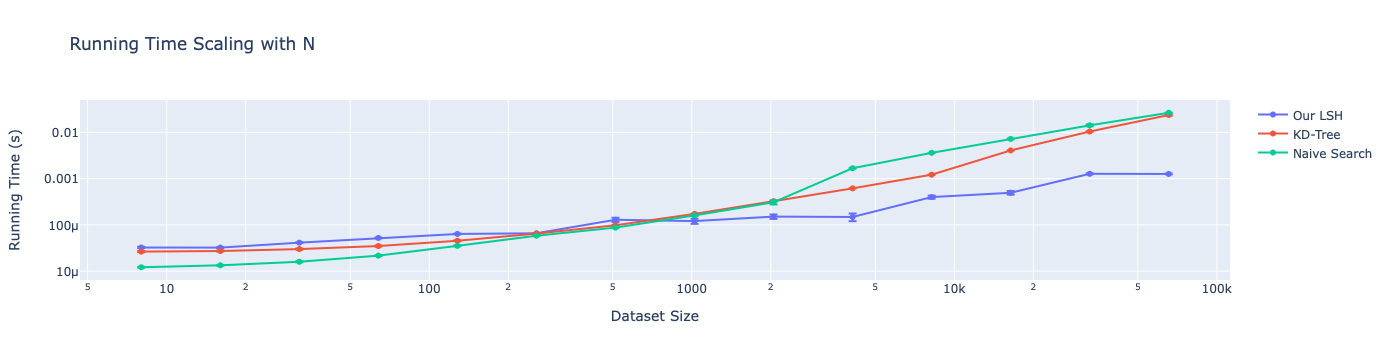

In [11]:
fig = go.Figure()

for name in ["Our LSH", "KD-Tree", "Naive Search"]:
    data = np.array(plot[name])
    fig.add_trace(
        go.Scatter(
            x= plot["x"], 
            y= data[:, 0],
            error_y= dict(
                type='data',
                array=data[:, 1],
                visible=True),
            name=name,
        )
    )

fig.update_xaxes(title_text="Dataset Size", type="log")
fig.update_yaxes(title_text="Running Time (s)", type="log")
fig.update_layout(title="Running Time Scaling with N")
fig.write_image("figures/runtime_vs_n.png", width=1200, height=350)
fig.show()

# k, L chart

In [ ]:
n_bins = 10
vec_size = 15
n_averaging = 3
L_values = [1, 2, 3]
k_values = [1, 2, 3]

charts = {}
for _ in tqdm(range(n_averaging)):
    dataset = np.random.rand( 300, vec_size )
    chart_names = []

    for L in tqdm(L_values, leave=False):
        ch_name = f"L={L}"
        chart_names.append(ch_name)
        
        if ch_name not in charts:
            charts[ch_name] = {}

        for k in tqdm(k_values, leave=False):
            table = L1_LSH(k=k, L=L, d=vec_size)

            probs = np.zeros((2, n_bins), dtype=int)
            for i in range(dataset.shape[0]):
                for j in range(i + 1, dataset.shape[0]):
                    l1_dist = np.sum(np.abs(dataset[i] - dataset[j]))
                    hist_cell = round(l1_dist / vec_size * n_bins)

                    # Denominator
                    probs[1, hist_cell] += 1
                    # Nominator
                    if table._collide(dataset[i], dataset[j]):
                        probs[0, hist_cell] += 1

            if f"k={k}" not in charts[ch_name]:
                charts[ch_name][f"k={k}"] = np.zeros_like(probs)
            charts[ch_name][f"k={k}"] += probs

In [ ]:
x_ticks = np.array(range(n_bins)) * vec_size / n_bins

fig = make_subplots(
    rows=1, cols=len(chart_names),
    subplot_titles=chart_names
)

colors = ["red", "blue", "green", "yellow", "black"]

for col_i, ch_name in enumerate(chart_names):
    for subplt_i, name in enumerate(charts[ch_name]):
        
        draw_idx = charts[ch_name][name][1] > 0
        values = charts[ch_name][name][0, draw_idx] / charts[ch_name][name][1, draw_idx]
        fig.add_trace(
            go.Scatter(
                    x=x_ticks[draw_idx], 
                    y=values,
                    name=name,
                    legendgroup=name,
                    showlegend=(col_i == 0),
                    line=dict(color=colors[subplt_i])
            ),
            row=1,
            col=col_i + 1,
        )

fig.update_xaxes(title_text="L1 distance")
fig.update_yaxes(title_text="P Collision", col=1)
fig.show()

fig.write_image("figures/kl_plot.png", width=1200, height=350)

## Misc

In [ ]:
data_path = "/mnt/arteml/data/meshsdf/cars/samples"
save_path = "/mnt/arteml/classes/6850/thirdparty/DeepSDF/examples/splits/"

files = list(filter(lambda x: x.endswith(".npz"), os.listdir(data_path)))

train_split = [{"model_id": x[:-4]} for x in files]
test_split  = []

with open(os.path.join(save_path, "CarOverfit.train.json"), 'w') as f:
    json.dump(train_split[:1], f)

with open(os.path.join(save_path, "Car.test.json"), 'w') as f:
    json.dump(test_split, f)

In [14]:
mesh = pv.read("/mnt/arteml/data/meshsdf/cars/reconstructions_we/100715345ee54d7ae38b52b4ee9d36a3.obj").points

In [16]:
mesh.min(axis=0), mesh.max(axis=0)

(pyvista_ndarray([-0.4448111 , -0.13052797, -0.18364076], dtype=float32),
 pyvista_ndarray([0.44617394, 0.325     , 0.18349144], dtype=float32))

In [29]:
pv.PolyData(sampled_points).save("test_pc.vtk")